<a href="https://colab.research.google.com/github/Abhishekkk2004/Deepseek-from-Scratch/blob/main/MultiHeadLatentAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

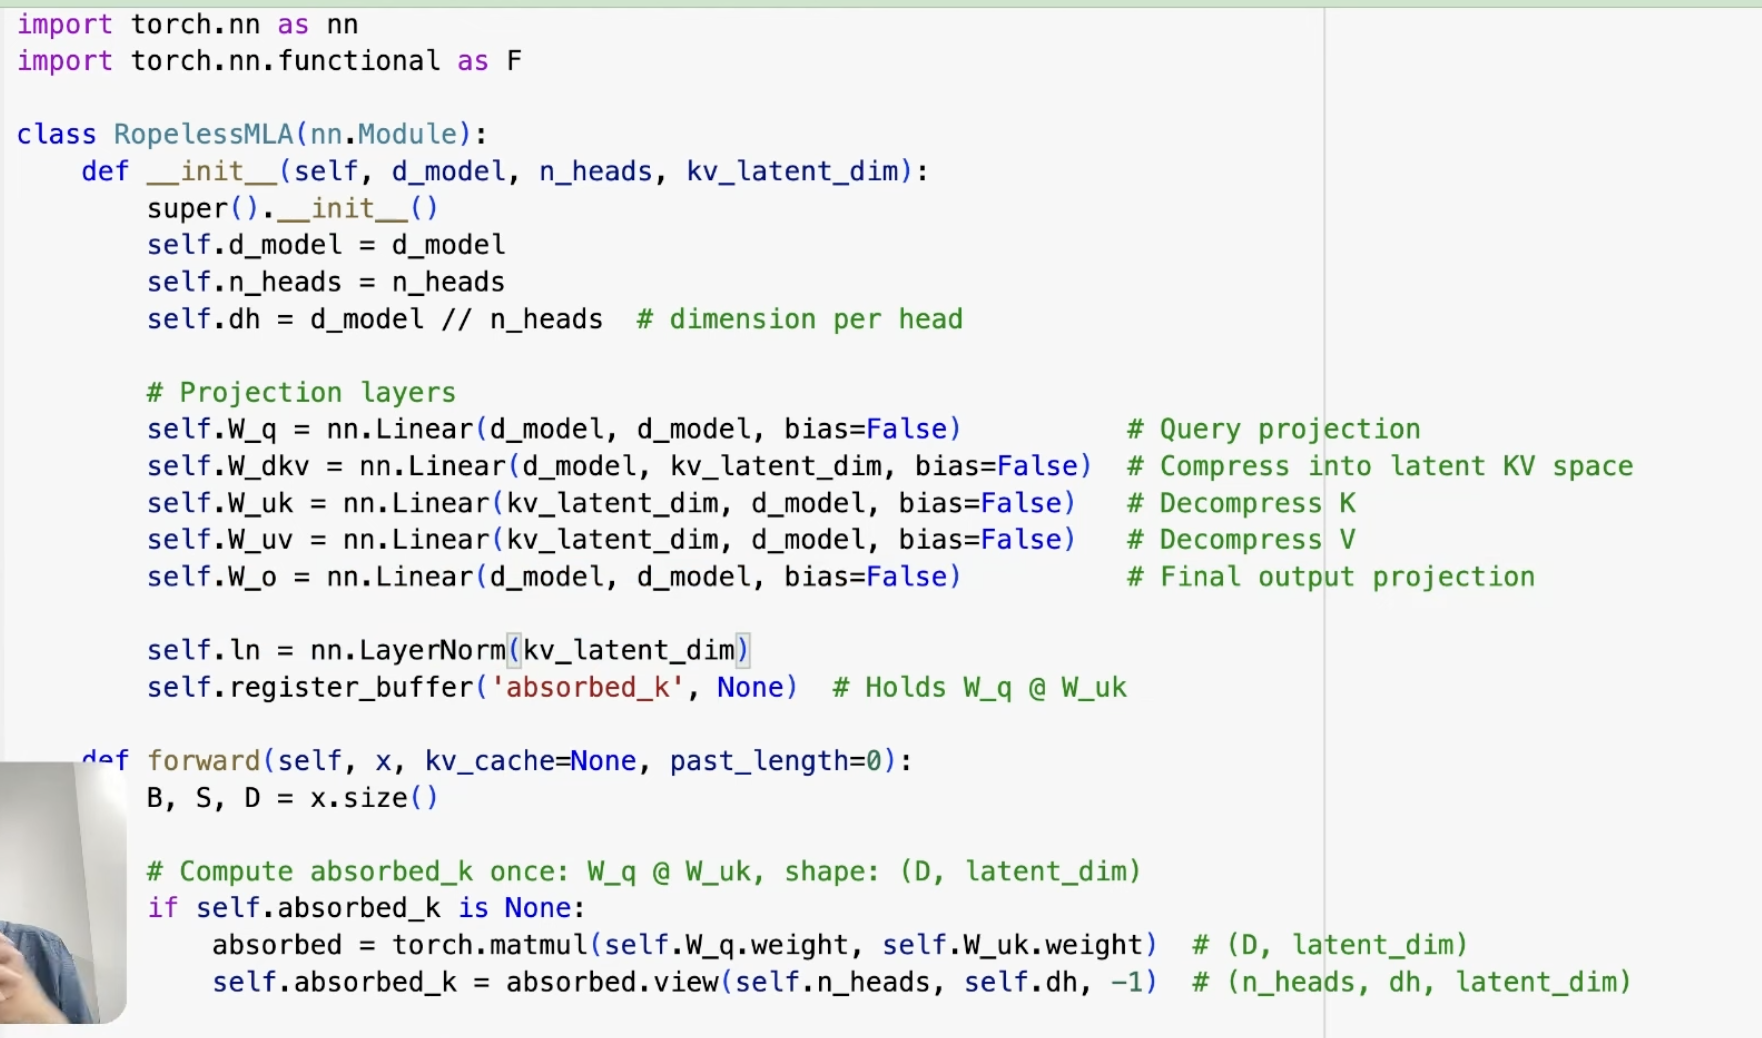

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RopelessMLA(nn.Module):
    def __init__(self, d_model, n_heads, kv_latent_dim):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads

        # Projection layers
        self.W_q = nn.Linear(d_model, d_model, bias=False)           # ( d_out, d_out)
        self.W_dkv = nn.Linear(d_model, kv_latent_dim, bias=False)   # ( d_out, KV_Cache_dim)
        self.W_uk = nn.Linear(kv_latent_dim, d_model, bias=False)    # ( KV_Cache_dim, d_out)
        self.W_uv = nn.Linear(kv_latent_dim, d_model, bias=False)    # ( KV_Cache_dim, d_out)

        # self.ln = nn.LayerNorm(d_model)
        self.ln_kv = nn.LayerNorm(kv_latent_dim)
        self.register_buffer('absorbed_k', None)

    def forward(self, x, kv_cache=None, past_length=0):
        """
        x: [B, S, D]
        kv_cache: [B, S_prev, latent_dim] or None
        past_length: int, for causal masking when using kv_cache
        """
        B, S, D = x.size()

        # Compute absorbed_k once: W_q @ W_uk.T → [D, latent_dim]
        if self.absorbed_k is None:
            # print(self.W_q.weight.shape)
            # print(self.W_uk.weight.shape)
            absorbed = torch.matmul(self.W_q.weight, self.W_uk.weight)  # ( d_out, KV_Cache_dim)
            self.absorbed_k = absorbed.view(self.n_heads, self.dh, -1)  # [H, dh, latent_dim]

        # Compress input into latent key/value space
        new_c_kv = self.ln_kv(self.W_dkv(x))  # [B, S, latent_dim]

        # Concatenate cache if present
        if kv_cache is None:
            c_kv = new_c_kv  # [B, S, latent_dim]
        else:
            c_kv = torch.cat([kv_cache, new_c_kv], dim=1)  # [B, S_total, latent_dim]

        S_full = c_kv.size(1)

        # Project values into full model dimension, split into heads
        v_full = self.W_uv(c_kv)  # [B, S_full, D]
        v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1, 2)  # [B, H, S_full, dh]

        # Use input x directly as query, reshape into heads
        q = x.view(B, S, self.n_heads, self.dh)  # [B, S, H, dh]

        # Attention scores
        attn_scores = torch.zeros(B, self.n_heads, S, S_full, device=x.device)

        for h in range(self.n_heads):
            tmp = torch.matmul(q[:, :, h], self.absorbed_k[h])  # [B, S, latent_dim]
            attn_scores[:, h] = torch.bmm(tmp, c_kv.transpose(1, 2))  # [B, S, S_full]

        # Scale scores and apply causal mask
        attn_scores = attn_scores / (self.dh ** 0.5)
        mask = torch.tril(torch.ones((S, S_full), device=x.device), diagonal=past_length)
        attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full) == 0, float('-inf'))

        # Softmax attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)  # [B, H, S, S_full]

        # Compute weighted sum of values
        out_heads = []
        for h in range(self.n_heads):
            context_h = torch.matmul(attn_weights[:, h], v[:, h])  # [B, S, dh]
            out_heads.append(context_h)

        # Concatenate heads
        out = torch.cat(out_heads, dim=-1)  # [B, S, D]

        return out, c_kv


In [ ]:
if __name__ == "__main__":
    B, S, D = 2, 5, 64
    H = 4
    LATENT = 32

    model = RopelessMLA(d_model=D, n_heads=H, kv_latent_dim=LATENT)
    dummy_input = torch.randn(B, S, D)

    output, cache = model(dummy_input)
    print("Output shape:", output.shape)   # [B, S, D]
    print("New KV Cache shape:", cache.shape)  # [B, S, LATENT]


torch.Size([64, 64])
torch.Size([64, 32])
Output shape: torch.Size([2, 5, 64])
New KV Cache shape: torch.Size([2, 5, 32])


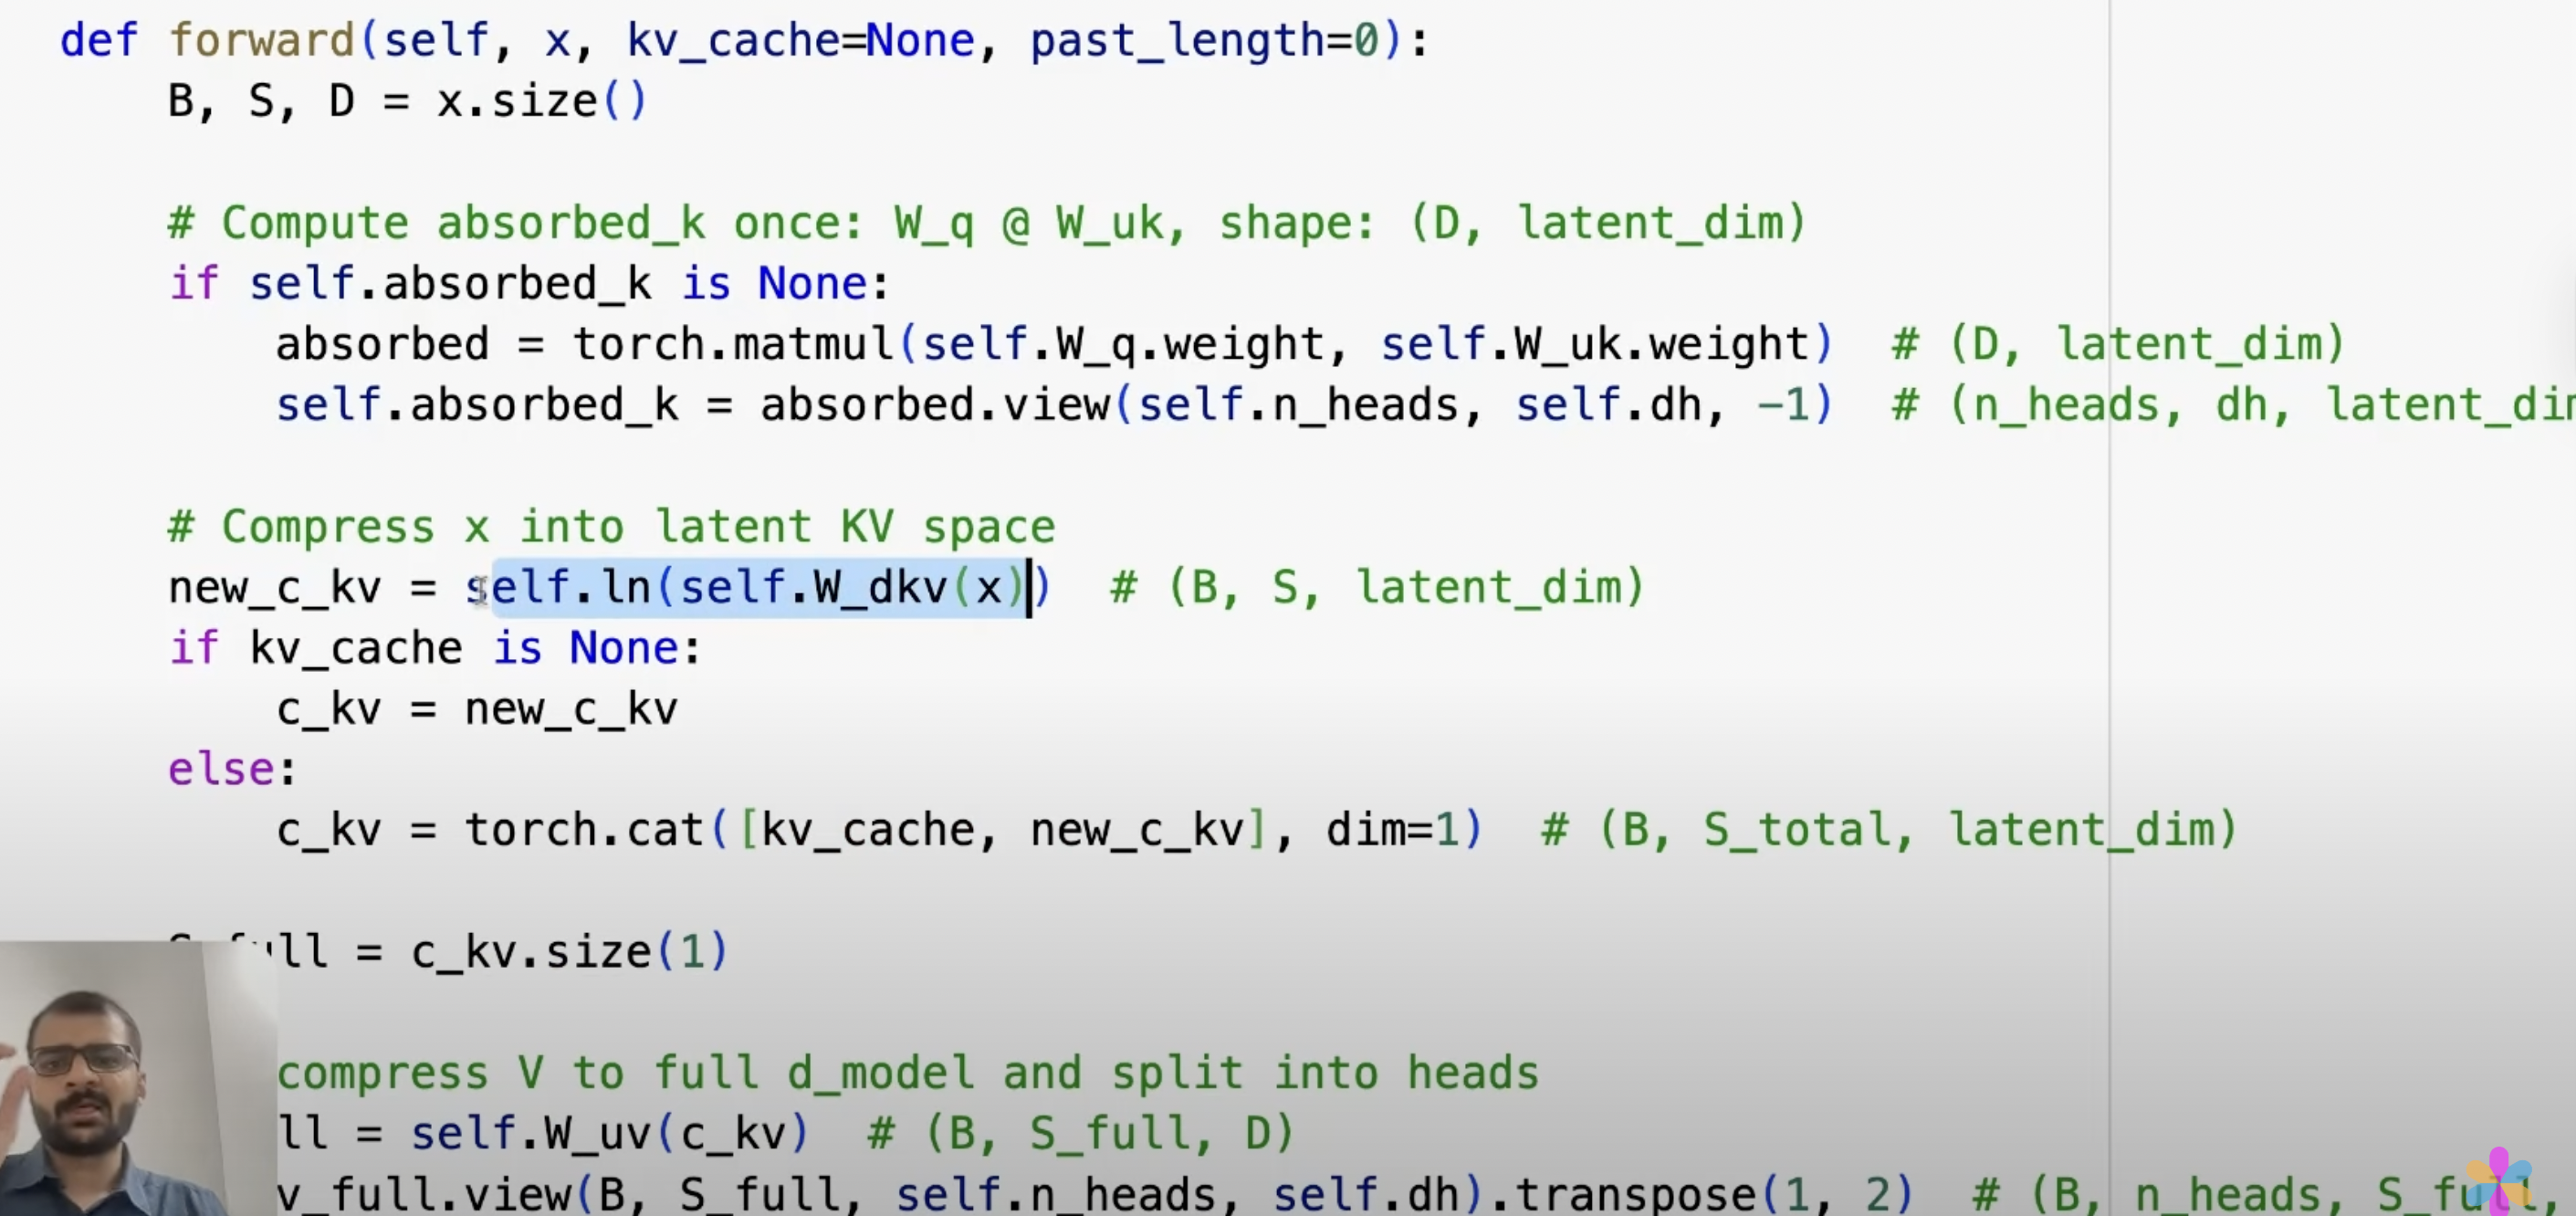

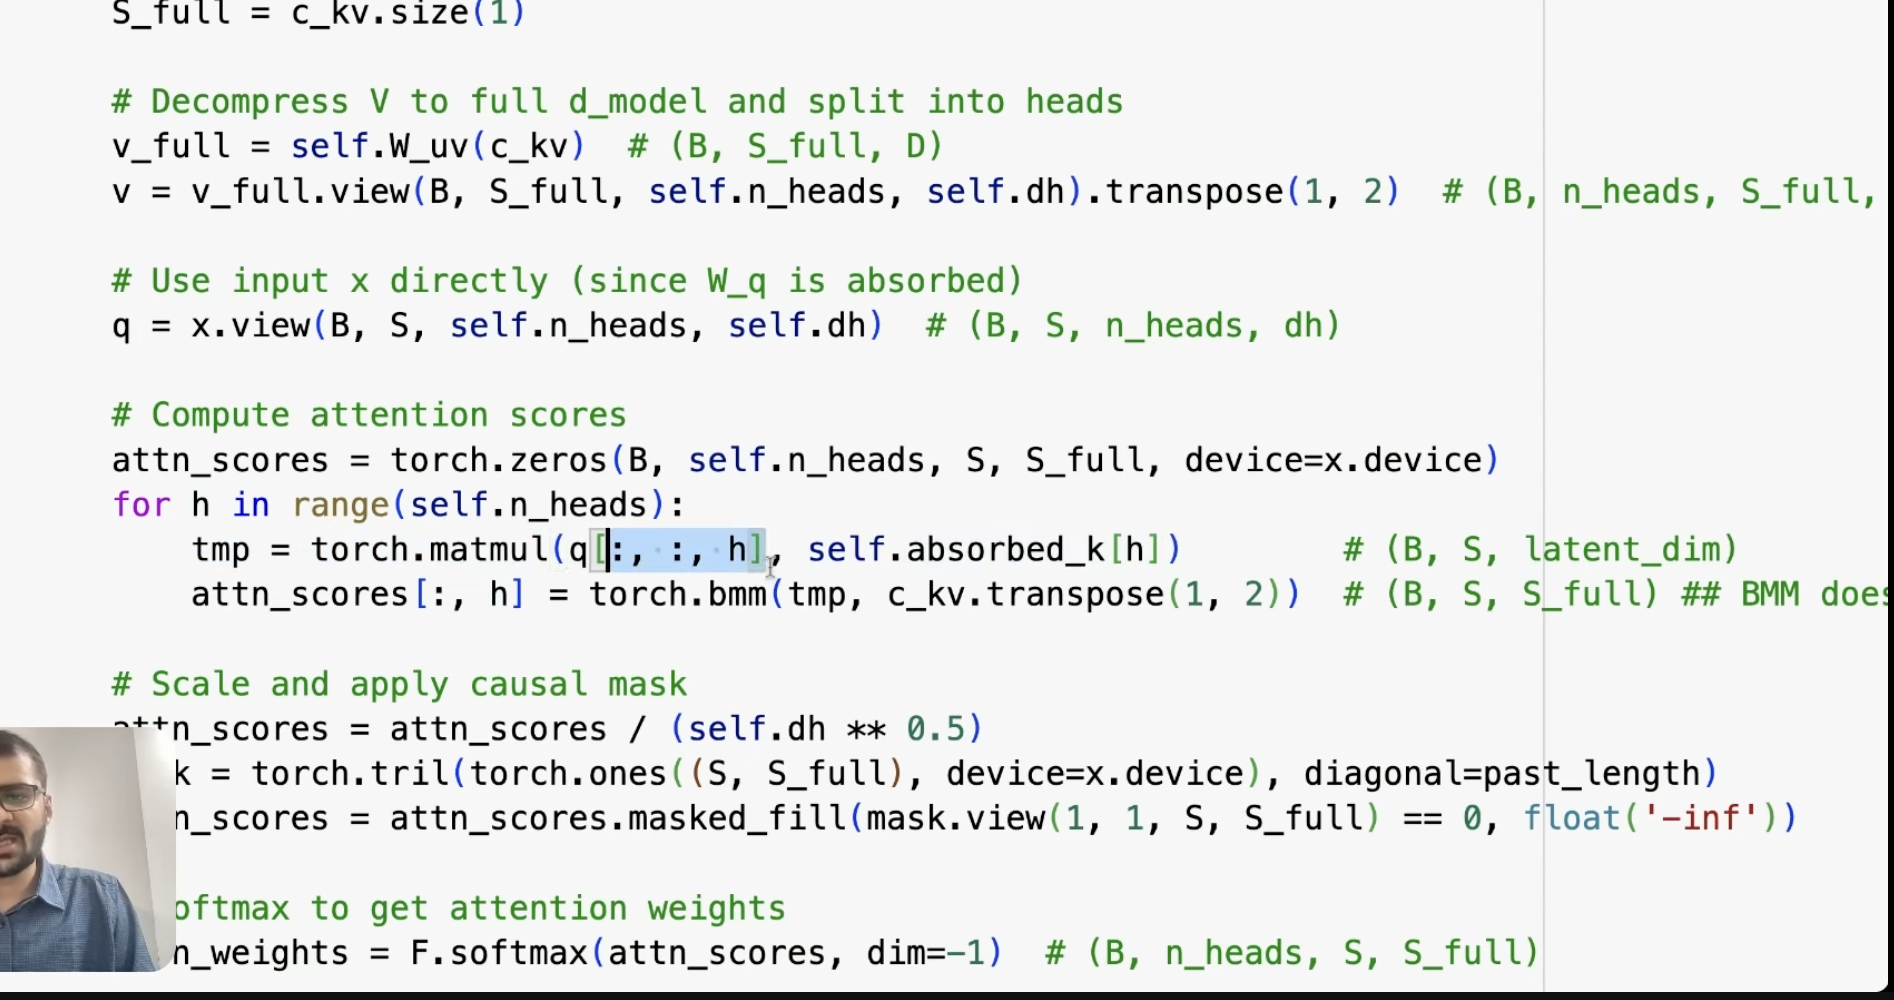

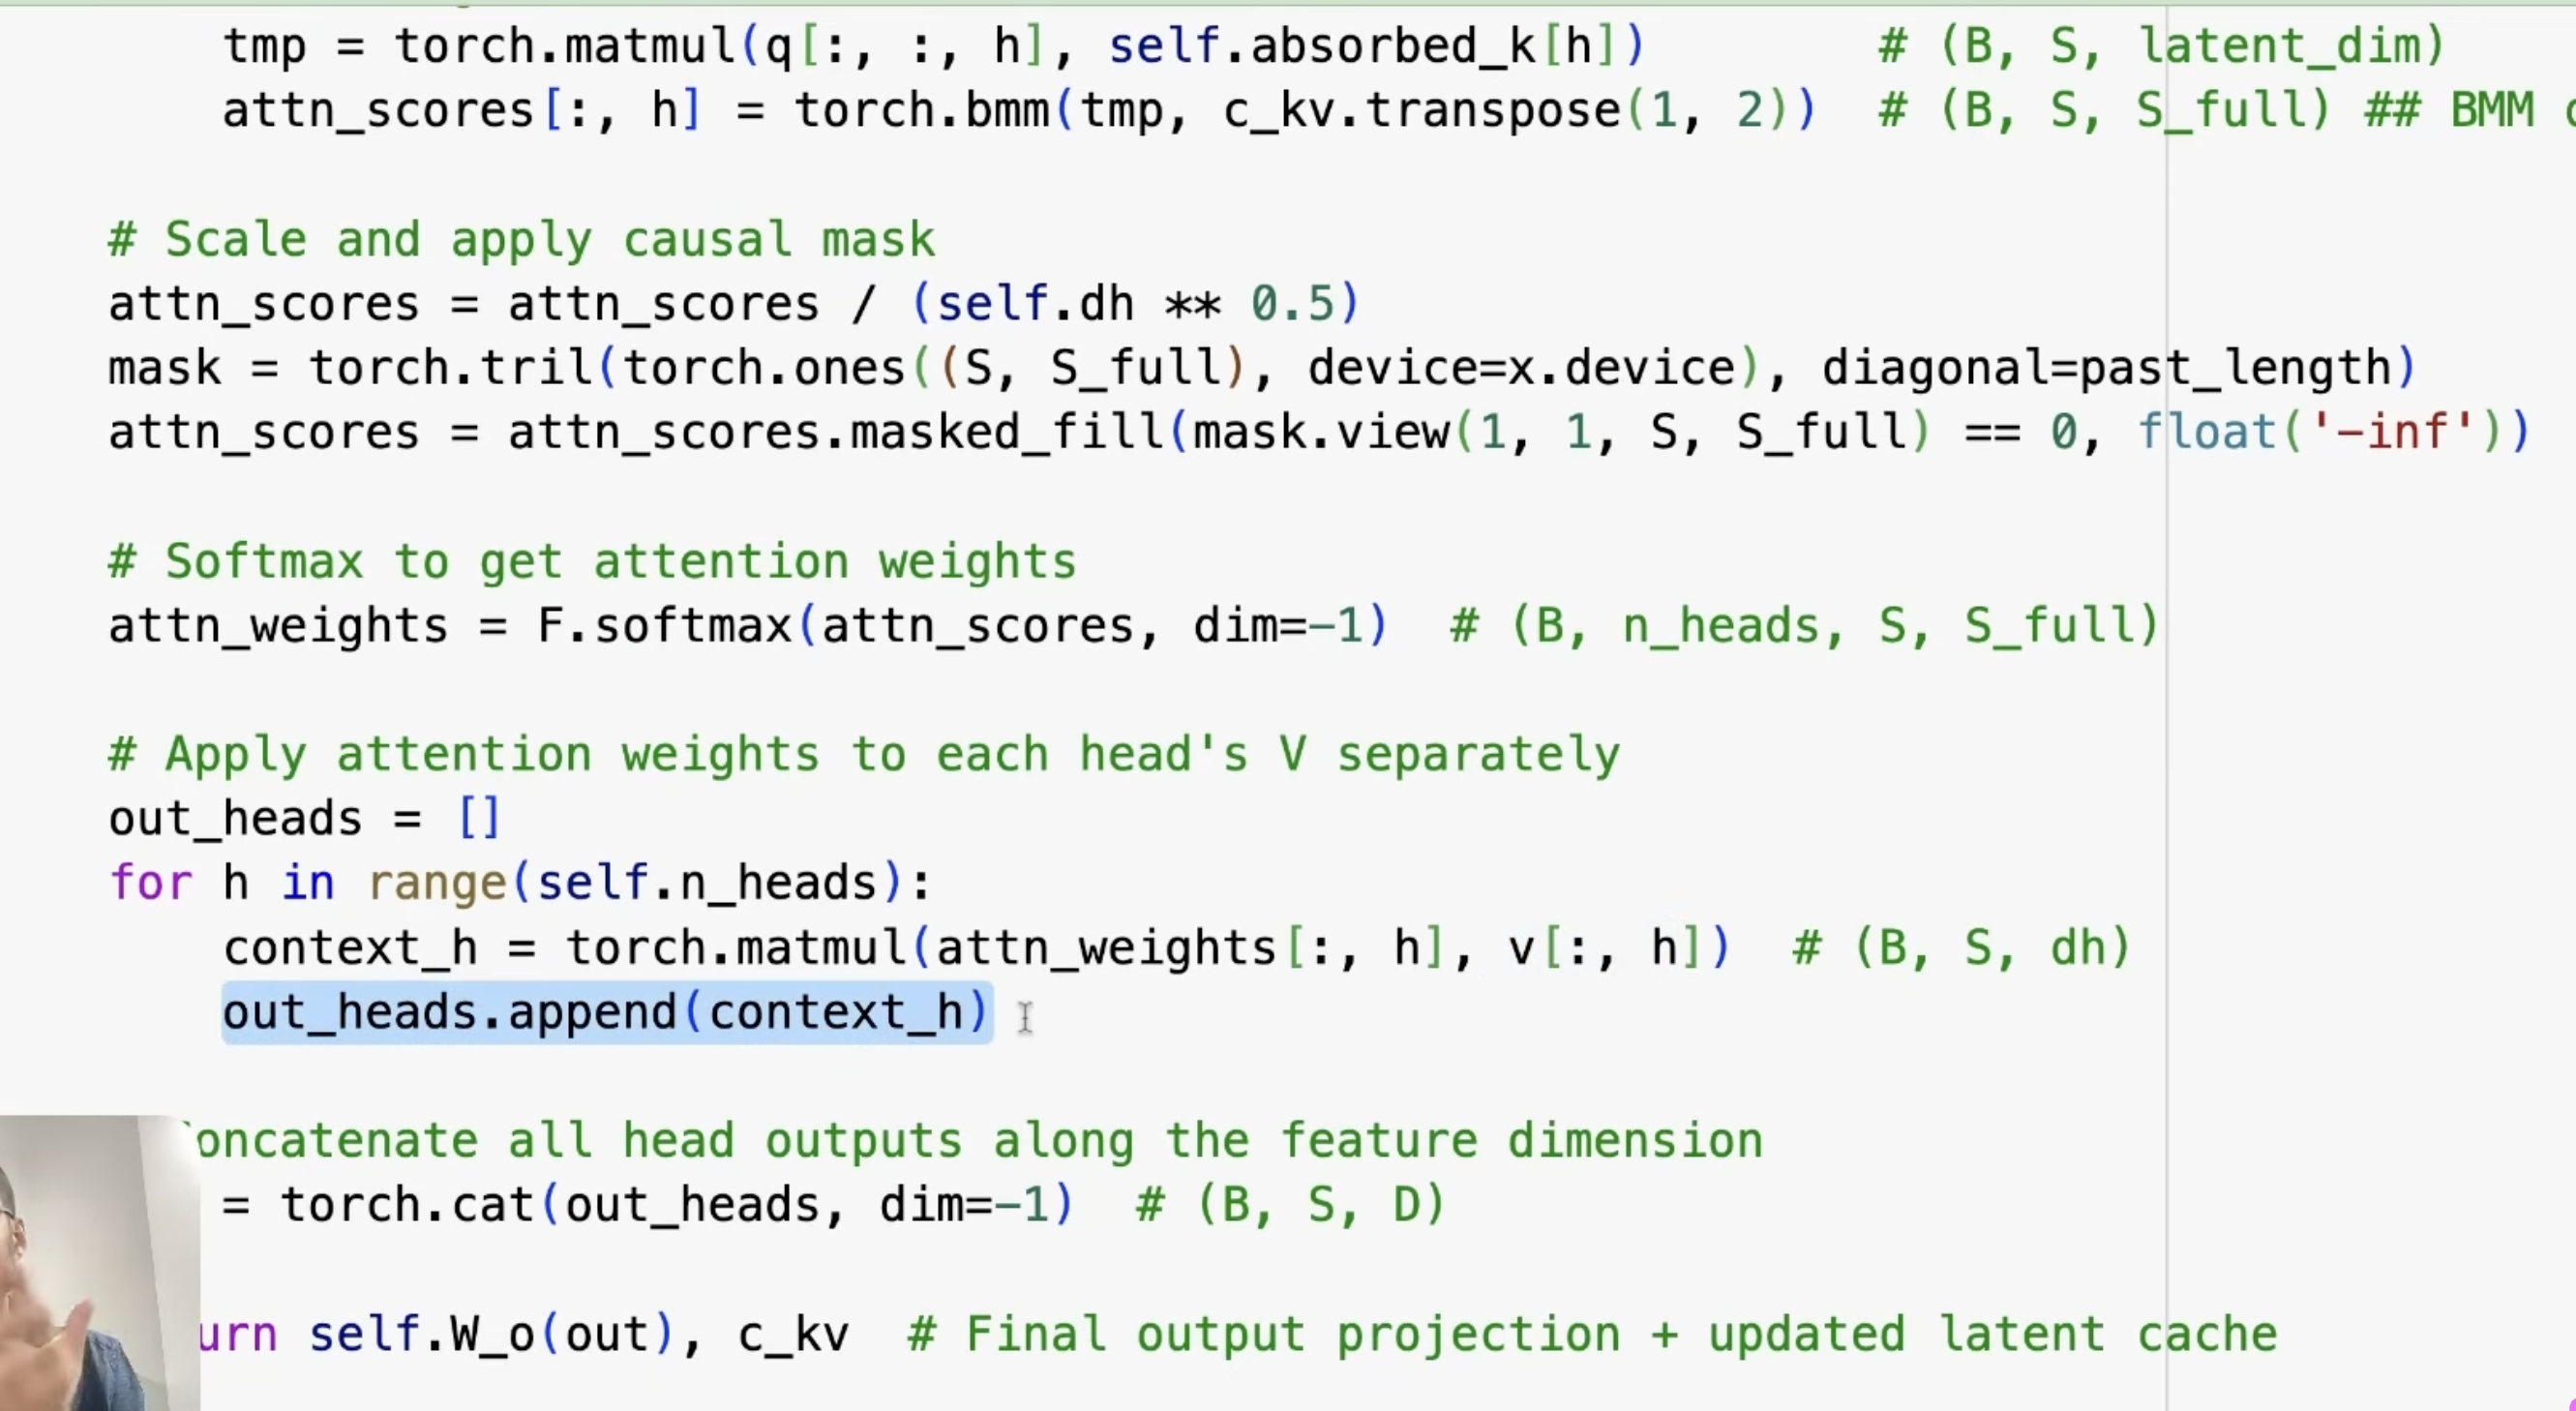